In [21]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [104]:
# import data for seasonal rankings
rankings_path = 'Data/Regular_Season/Rankings/*'
df_rankings = []

for file in glob.iglob(rankings_path):
    frame = pd.read_csv(file,sep=';')
    frame['Season'] = file[29:34]
    df_rankings.append(frame)
df_rankings = pd.concat(df_rankings)
df_rankings.columns

Index(['R', 'Team', 'GP', 'W', 'OTW', 'SOW', 'SOL', 'OTL', 'L', 'GF', 'GA',
       'GDF', 'PTS', 'Season'],
      dtype='object')

In [105]:
# helper to sort plots by median rank/pts
temp = df_rankings.groupby('Team').agg({'R': 'median', 'PTS': 'median'})
t1 = temp.sort_values(by='R',inplace=False)
t2 = temp.sort_values(by='PTS',ascending=False)

In [106]:
df_rankings = df_rankings.groupby(by=['Team', 'Season'], as_index=True).agg({'R': 'first', 'PTS': 'first'})

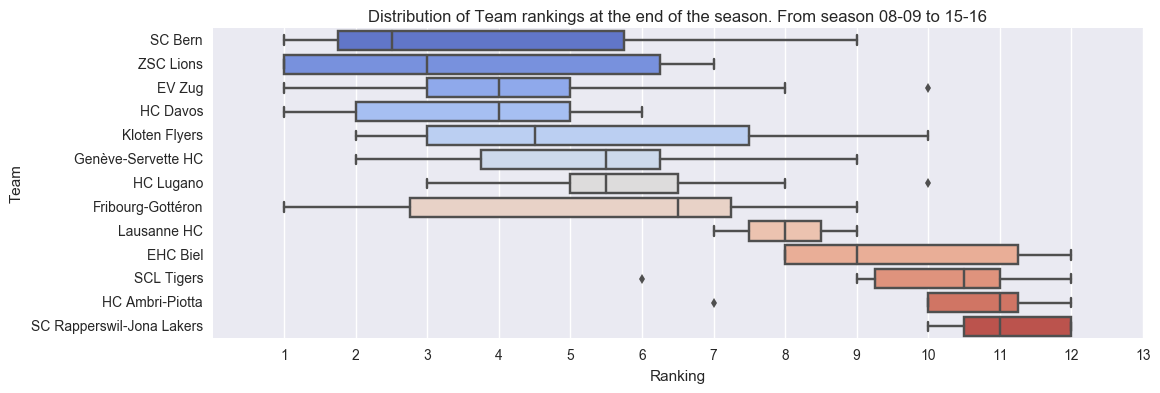

In [107]:
# plot
plt.figure(figsize=(12,4))
ax = sns.boxplot(x='R', y='Team',data=df_rankings.reset_index(), orient="h", palette='coolwarm', order=t1.index)
ax.set_xlabel('Ranking')
ax.set_xticks(np.arange(1,14))
ax.set_title('Distribution of Team rankings at the end of the season. From season 08-09 to 15-16');

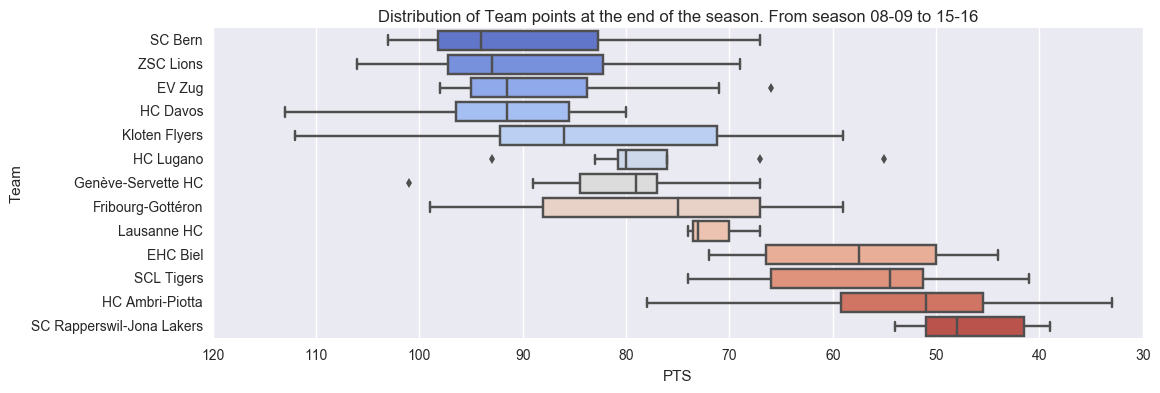

In [110]:
plt.figure(figsize=(12,4))
ax = sns.boxplot(x='PTS', y='Team',data=df_rankings.reset_index(), orient="h", palette='coolwarm', order=t2.index)
ax.set_xlabel('PTS')
ax.invert_xaxis()
#ax.set_xticks(np.arange(1,14))
ax.set_title('Distribution of Team points at the end of the season. From season 08-09 to 15-16');

In [ ]:
df_rankings.plot()